In [9]:
%run init_notebook.py

In [10]:
import pandas as pd
import numpy as np

import lightgbm

import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt

In [11]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [12]:
# Load data
model_type = "ols"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

year_start = 2011
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [13]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'

data compromises 10 years: 2764 lines


In [14]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)

data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))
data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [15]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     'sp_close_lag8',
     'sp_close_lag9',
     'sp_close_lag10'
]

categorical = [
         'weekday'
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]


## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [16]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# TTS

In [17]:
df_train = df_ws.copy()

In [18]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.2,
                                            add_const=False)

# Seasonality

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
## SEASONALITY DF
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# filter for complete weeks only
_ = X_train_sea.groupby("week").weekday.count() == 5
_ = _[_].index
X_train_sea = X_train_sea[X_train_sea["week"].isin(_)]

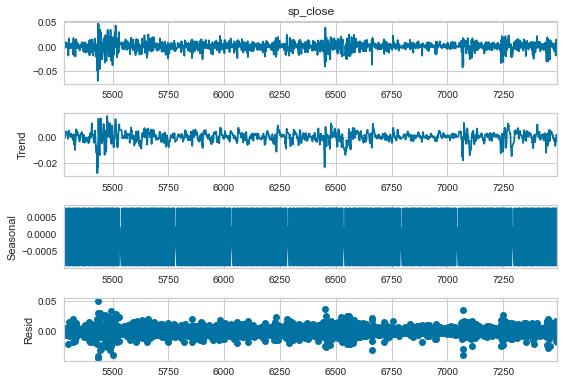

In [21]:
## SEASONALITY ANALYSIS
# create statsmodel seasonality object
sd = seasonal_decompose(X_train_sea.sp_close, period=5)
sd.plot()
plt.show()

In [22]:
# get seasonality by weekday
X_train_sea["seasonal"] = sd.seasonal
data_dict["model_features"].update(weekday_seasonality= dict(zip(X_train_sea.groupby("weekday").seasonal.first().index, X_train_sea.groupby("weekday").seasonal.first().values)))

In [23]:
# map sesonality to data
_ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

_ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

In [24]:
cols.append("seasonal")

# Corr

In [25]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Lag corr

In [26]:
df_cross_corr(X_train,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]],
              data_dict["model_features"]["predicted"],
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[['ff_M_RF', 4, 0.093],
 ['ff_SMB', 4, 0.047],
 ['ff_HML', 12, 0.047],
 ['ff_RMW', 4, 0.057],
 ['ff_CMA', 5, 0.045],
 ['weekday', 0, 0.037],
 ['seasonal', 4, 0.041]]

In [27]:
# X_train, _ = shift_var_relative_to_df(X_train,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# X_test, _ = shift_var_relative_to_df(X_test,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# data_dict["data_transformation"].update(shift_var=_)
# X_train = X_train.dropna()
# X_test = X_test.dropna()

Corr matrix

In [28]:
## ORTHOGONALISE
# df_ws = orthogonalise_vars(df_ws, X="sp_close", y="ff_M_RF", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close_lag4,1.020494,-0.088873
sp_close,511.419519,-0.046275
ff_HML,1.557815,-0.046147
sp_close_lag2,1.030486,-0.044307
ff_M_RF,540.272625,-0.043678
seasonal,1.074351,-0.038961
weekday,1.159257,-0.037404
sp_close_lag8,1.018475,-0.030284
sp_close_lag7,1.019753,-0.012515
sp_close_lag3,1.023664,-0.010348


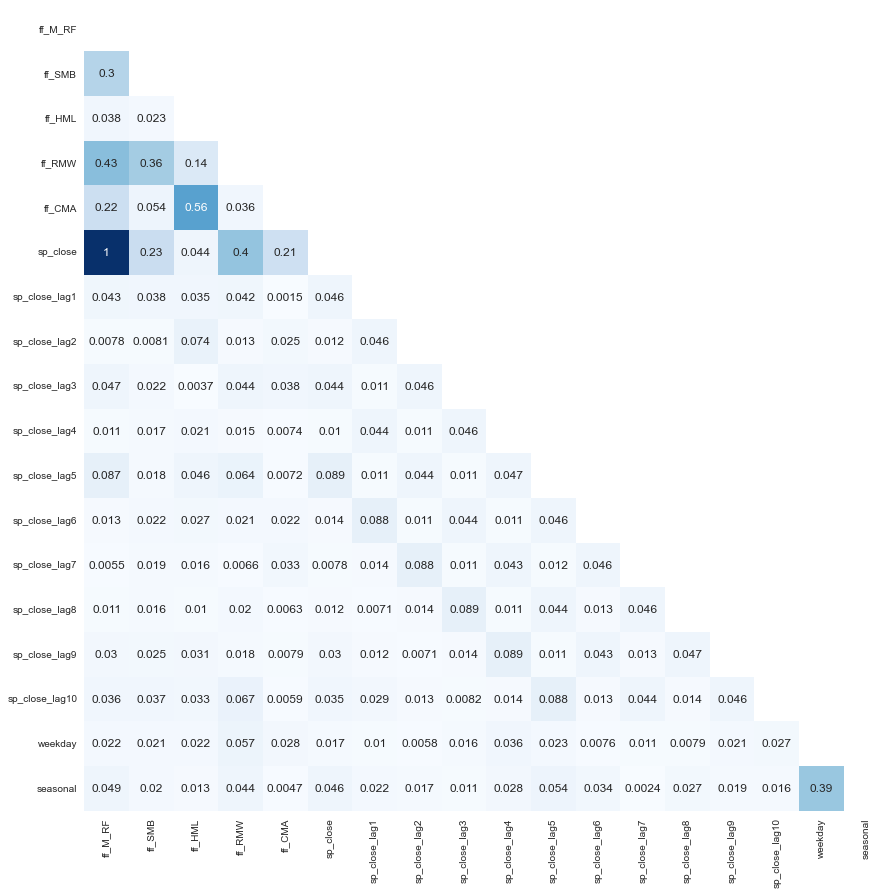

In [29]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

In [30]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

# Standard Scaling

In [31]:
# not required for lgbm

In [32]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(X_train)
# X_train = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)

In [33]:
data_dict["data_transformation"].update(standard_scaling={"scaled_cols": data_dict["model_features"]["predictor"],
                                                          "scaler_x": scaler_x})

# Tuner

In [34]:
tuner_params = {
    'objective': 'regression',
    'metric': ['rmse'],
    'random_state': random_state,
    'categorical_feature': [X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]]
}

tuner_train = lightgbm.Dataset(X_train, y_train, categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]])
tuner_eval = lightgbm.Dataset(X_test, y_test, categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]], reference=tuner_train)
tuner_eval_results = {}
training_time = 60 * 20

In [ ]:
%%capture
my_study = optuna.study.create_study()

t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(10000), lightgbm.record_evaluation(tuner_eval_results)]
                               )
tuner.run()
t_end = dt.datetime.now()

[I 2022-03-21 16:16:28,544] A new study created in memory with name: no-name-9bde6770-26c0-4646-be99-a57d9b1b7a86
[I 2022-03-21 16:16:29,743] Trial 0 finished with value: 0.01574765156762483 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.01574765156762483.
[I 2022-03-21 16:16:30,849] Trial 1 finished with value: 0.01574765156762483 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.01574765156762483.
[I 2022-03-21 16:16:31,993] Trial 2 finished with value: 0.01574765156762483 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.01574765156762483.
[I 2022-03-21 16:16:33,298] Trial 3 finished with value: 0.01574765156762483 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.01574765156762483.
[I 2022-03-21 16:16:34,534] Trial 4 finished with value: 0.01574765156762483 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.01574765156762483.
[I 2022-03-21 16:16:35,602

In [ ]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

In [ ]:
# params = {'objective': 'regression',
#  'metric': ['log_loss', 'rmse'],
#  'random_state': 101,
#  'feature_pre_filter': False,
#  'lambda_l1': 0.0,
#  'lambda_l2': 0.0,
#  'num_leaves': 31,
#  'feature_fraction': 1.0,
#  'bagging_fraction': 0.6654319485899407,
#  'bagging_freq': 2,
#  'min_child_samples': 20}

In [ ]:
params = tuner.best_params

In [ ]:
params = {item: params[item] for item in params.keys() if item != "categorical_feature"}

# Model

In [ ]:
lgb_train = lightgbm.Dataset(X_train, y_train, categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]], free_raw_data=False)
lgb_test = lightgbm.Dataset(X_test, y_test, categorical_feature=[X_test.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]], free_raw_data=False, reference=lgb_train)
evals_result = {} 

In [ ]:
%%capture
model = lightgbm.train(params,
                           lgb_train,
                           num_boost_round=1000,
                           valid_sets=[lgb_test, lgb_train],
                           callbacks=[lightgbm.early_stopping(100000), lightgbm.record_evaluation(evals_result)])

data_dict["model_features"].update(params=params)

In [ ]:
params

# Model eval

In [ ]:
X_test.shape

In [ ]:
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=model,
                          print_results=True)

fig_truefit = lgb_eval.get_model_performance()
stat, norm, hetero = lgb_eval.analyse_resids()
fig_lcurve = lgb_eval.lgbm_learning_curve(params, lgb_train, lgb_test, "Model Learning Curve", n_splits=10)
fig_prices = lgb_eval.plot_results_on_price_scale(df_w,
                                                  df_ws,
                                                  sp_true_vals=data_dict["data"]["sp_true_vals"],
                                                  show_pred_only=True)

#update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=lgb_eval.mse)
data_dict["model_metrics"].update(mae=lgb_eval.mae)
data_dict["model_metrics"].update(r2=lgb_eval.r2)
data_dict["model_metrics"].update(residuals=lgb_eval.resid_inv)

# Save model

In [47]:
data_dict["model_metrics"]["model_name"]

KeyError: 'model_name'

In [48]:
save_model(model, df_train, data_dict, fig_truefit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

KeyError: 'model_name'